In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
import pickle
import csv
import math
import os

In [2]:
cmaps = ['Greys', 'Reds', 'Purples', 'Blues', 'Greens', 'Oranges', 'PuBu', 'YlOrRd']
bodyparts = ["nose_1", "head_1", "middle_body_1", "tailbase_1", "nose_2", "head_2", "middle_body_2", "tailbase_2"]

In [3]:
def load_csv(fp):
    with open(fp, 'r') as f:
        lines = f.readlines()
    return np.genfromtxt(lines, delimiter=',', names=True, skip_header=True)

In [4]:
bp = Path('/home/melisa/Documents/social_interaction/')
bp.exists()

csp = bp / 'unbiased'
res1 = load_csv(list(csp.glob('*.csv'))[0])
#plot_traces(res1, 32, 6, 'full_duration unbiased', line_alpha=0.5)

csp = bp / 'pos09_neg09'
res2 = load_csv(list(csp.glob('*.csv'))[0])
#plot_traces(res2, 32, 6, 'full_duration +0.9/-0.9', line_alpha=0.5)

#print((res1[1]))

numpy.ndarray

In [6]:
import numpy.linalg as npalg

def head_direction(pos):
    # get head direction coordinates
    x_diff = pos[1,0] - pos[0,0]
    y_diff = pos[1,1] - pos[0,1]
    hd = np.array([x_diff , y_diff])
    hd = hd / npalg.norm(hd)
    return hd

def body_direction(pos):
    # get body direction coordinates
    x_diff = pos[0,2] - pos[0,1]
    y_diff = pos[1,2] - pos[1,1]
    bd = np.array([x_diff , y_diff])
    #bd = bd / npalg.norm(bd)
    return bd

def distance(point1,point2):
    xdiff = point1[0] - point2[0]
    ydiff = point1[1] - point2[1]
    dist = np.sqrt(xdiff*xdiff + ydiff*ydiff)
    return dist

def get_parameters(pos1,pos2):
    
    #define centre of mass
    cm1 = np.mean(pos1,axis=1)
    cm2 = np.mean(pos2,axis=1)
    cm_dist = distance(np.array(cm1),np.array(cm2))
    
    #define distance between heads
    head1 = np.array((pos1[0,0],pos1[1,0]))
    head2 = np.array((pos2[0,0],pos2[1,0]))
    head_dist = distance(head1,head2)

    #define distance between head and tail
    tail1 = np.array((pos1[0,3],pos1[1,3]))
    tail2 = np.array((pos2[0,3],pos2[1,3]))
    head_tail_dist1 = distance(head1,tail2)
    head_tail_dist2 = distance(head2,tail1)
    
    #define body-body distance
    body1 = np.array((pos1[0,2],pos1[1,2]))
    body2 = np.array((pos2[0,2],pos2[1,2]))
    #body_dist = distance(body1,body2)
    body_dist = cm_dist

    #define head direction
    bd1 = body_direction(pos1)
    bd2 = body_direction(pos2)
    direction = np.dot(bd1,bd2)
    
    parameters = {'cm1-cm2': cm_dist, 'h1-h2': head_dist, 'h1-t2': head_tail_dist1, 'h2-t1': head_tail_dist2, 'b1-b2': body_dist, 'direction': direction }
    
    return parameters

In [7]:
def define_interaction(pos1,pos2):

    # define the type of interaction based in distances and other parameters
    parameters = get_parameters(pos1,pos2)
    interaction = 0
    if parameters['cm1-cm2'] < 50:
        interaction = 1
        return interaction
    if parameters['h1-h2'] < 50:
        interaction = 2
        return interaction
    if parameters['h1-t2'] < 75:
        interaction = 3
        return interaction
    if parameters['h2-t1'] < 75:
        interaction = 4
        return interaction
    if parameters['direction'] > 0 and parameters['b1-b2'] < 100 and parameters['h1-h2'] < 100:
        interaction = 5
        return interaction
    if parameters['direction'] < 0 and parameters['b1-b2'] < 100 and parameters['h1-h2'] < 100:
        interaction = 6
        return interaction
    return interaction

In [8]:
def temporal_evolution(res):
    #separate position1 and position2 from each animal
    pos1 = [np.array([[r[1],r[4],r[7],r[10]],[r[2],r[5],r[8],r[11]]]) for r in res[1:]]
    pos2 =[np.array([[r[13],r[16],r[19],r[22]],[r[14],r[17],r[20],r[23]]]) for r in res[1:]]
    return [pos1,pos2]

In [9]:
def temporal_ethogram(res):
    [pos1,pos2] = temporal_evolution(res)
    interaction = [define_interaction(x1,y1) for x1, y1 in zip(pos1,pos2)]
    return interaction

In [10]:
def temporal_parameters(res):
    [pos1,pos2] = temporal_evolution(res)
    parameters = [get_parameters(animal1,animal2) for animal1,animal2 in zip(pos1,pos2)]
    return parameters

In [12]:
interaction_vector1 = temporal_ethogram(res1)
[pos1,pos2] = temporal_evolution(res2)
interaction_vector2 = temporal_ethogram(res2)
parameters_vector = temporal_parameters(res2)
#body_direction1_vector =[body_direction(x1) for x1 in pos1]
#body_direction2_vector = [body_direction(x2) for x2 in pos2]

In [34]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(interaction_vector2, interaction_vector1)

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]


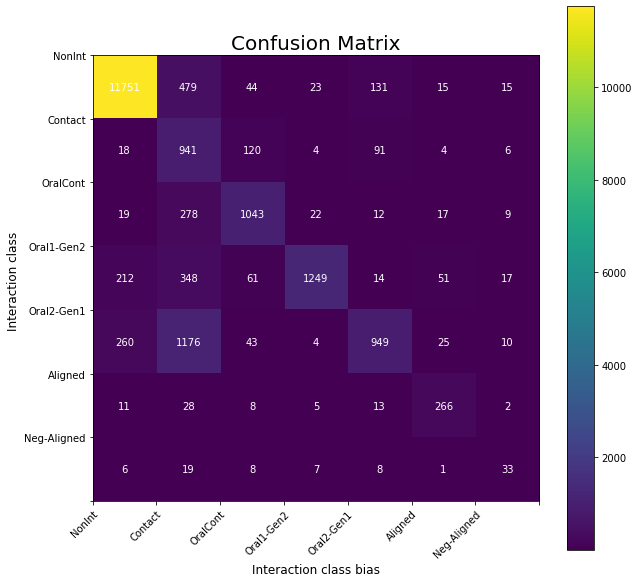

In [56]:
fig , axes = plt.subplots(1)
labels = ['NonInt','Contact','OralCont','Oral1-Gen2','Oral2-Gen1','Aligned','Neg-Aligned']
confusion = np.zeros_like(matrix)
for i in range(7):
    confusion[i,:]=matrix[i,:]#/np.sum(matrix[i,:])
    #confusion[i,i]= 0
x = axes.imshow(confusion)
x_pos = -0.5+np.arange(len(labels)+1)
print(x_pos)
axes.set_title('Confusion Matrix',fontsize = 20)
axes.set_ylabel('Interaction class ', fontsize = 12)
axes.set_xlabel('Interaction class bias', fontsize = 12)
axes.set_xticks(x_pos)
axes.set_xticklabels(labels)
axes.set_yticks(x_pos)
axes.set_yticklabels(labels)
plt.setp(axes.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.setp(axes.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        text = axes.text(j, i, round(confusion[i, j],5),
                       ha="center", va="center", color="w")    
fig.colorbar(x, ax = axes)
fig.set_size_inches(10, 10)
figure_name = bp / 'figures/confusion_matrix.png'
fig.savefig(figure_name)


In [ ]:
## create a video with cathegory labels

import cv2

input_video_path_dlc = '/home/melisa/Documents/social_interaction/m57697-05232018125955-0000.avi'
output_video_path = '/home/melisa/Documents/social_interaction/m57697-05232018125955-0000_interaction_bias.avi'
interaction_vector = interaction_vector2
font = cv2.FONT_HERSHEY_SIMPLEX

if not os.path.isfile(input_video_path_dlc):
    print('ERROR: File not found')
cap_dlc = cv2.VideoCapture(input_video_path_dlc)
try:
    length = int(cap_dlc.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap_dlc.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_dlc.get(cv2.CAP_PROP_FRAME_HEIGHT))
except:
    #logging.info('Roll back to opencv 2')
    length = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
    width = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH))
    height = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT))
if length == 0 or width == 0 or height == 0:  # CV failed to load
    cv_failed = True
    
dims_dlc = [length, height, width]
limits = False
ret, frame = cap_dlc.read()

### create a new video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
output_video_dlc = cv2.VideoWriter(output_video_path, fourcc, 30, (width ,height))

color1 = (255, 0, 0)
color2 = (0, 0, 255)

color3 = (0, 255, 0)

color_text = (255,255,255)

# Line thickness of 5 px
thickness = 5
time = 0
while True:
    ret, frame = cap_dlc.read()
    if not ret:
        break
    #if time % 2 == 0:
    interaction = interaction_vector[time]
    pt1_1 = (int(pos1[time][0,2]),int(pos1[time][1,2]))
    pt2_1 = (int(pos1[time][0,1]),int(pos1[time][1,1]))

    pt1_2 = ((int(pos2[time][0,2]),int(pos2[time][1,2])))
    pt2_2 = ((int(pos2[time][0,1]),int(pos2[time][1,1])))

    cv2.arrowedLine(frame, pt1_1, pt2_1, color1, 5, 8)
    cv2.arrowedLine(frame, pt1_2, pt2_2, color2, 5, 8)

    if interaction == 0:
        cv2.putText(frame, 'No Int', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
    if interaction == 1:
        cv2.putText(frame, 'Contact', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
        center_coordinates1 = (int(pos1[time][0,2]),int(pos1[time][1,2]))
        center_coordinates2 = (int(pos2[time][0,2]),int(pos2[time][1,2]))
        cv2.circle(frame,center_coordinates1,25,color3,thickness)
        cv2.circle(frame,center_coordinates2,25,color3,thickness)
        cv2.line(frame, center_coordinates1, center_coordinates2, color3, thickness)
        cv2.putText(frame, str(int(parameters_vector[0]['cm1-cm2'])), (50, 450),font, 3,color3, 2, cv2.LINE_AA)

    if interaction == 2:
        cv2.putText(frame, 'Oral-Contact', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
        center_coordinates1 = (int(pos1[time][0,0]),int(pos1[time][1,0]))
        center_coordinates2 = (int(pos2[time][0,0]),int(pos2[time][1,0]))
        cv2.circle(frame,center_coordinates1,25,color3,thickness)
        cv2.circle(frame,center_coordinates2,25,color3,thickness)
        cv2.line(frame, center_coordinates1, center_coordinates2, color3, thickness)
        cv2.putText(frame, str(int(parameters_vector[0]['h1-h2'])), (50, 450),font, 3,color3, 2, cv2.LINE_AA)

    if interaction == 3:
        cv2.putText(frame, 'Oral-Genital1', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
        center_coordinates1 = (int(pos1[time][0,0]),int(pos1[time][1,0]))
        center_coordinates2 = (int(pos2[time][0,3]),int(pos2[time][1,3]))
        cv2.circle(frame,center_coordinates1,25,color3,thickness)
        cv2.circle(frame,center_coordinates2,25,color3,thickness)
        cv2.line(frame, center_coordinates1, center_coordinates2, color3, thickness)

    if interaction == 4:
        cv2.putText(frame, 'Oral-Genital2', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
        center_coordinates1 = (int(pos1[time][0,3]),int(pos1[time][1,3]))
        center_coordinates2 = (int(pos2[time][0,0]),int(pos2[time][1,0]))
        cv2.circle(frame,center_coordinates1,25,color3,thickness)
        cv2.circle(frame,center_coordinates2,25,color3,thickness)

    if interaction == 5:
        cv2.putText(frame, 'Aligned', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
        cv2.arrowedLine(frame, pt1_1, pt2_1, color3, 5, 8)
        cv2.arrowedLine(frame, pt1_2, pt2_2, color3, 5, 8)
    if interaction == 6:
        cv2.putText(frame, 'Neg Aligned', (10, 450),font, 3,color_text, 2, cv2.LINE_AA)
        cv2.arrowedLine(frame, pt1_1, pt2_1, color3, 5, 8)
        cv2.arrowedLine(frame, pt1_2, pt2_2, color3, 5, 8)
        cv2.waitKey(0)
    output_video_dlc.write(frame)
    time = time + 1